In [2]:
import os
import torch
import torch.nn.functional as F
import polars as pl
from torch.utils.data import DataLoader, TensorDataset
from vector_quantize_pytorch import ResidualVQ
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from utils.file_config import FILE_CONFIG as fc
import utils.evaluation as eval_utils
from copy import deepcopy
import pickle



# === Config ===
class Config:
    alpha = 0
    num_epochs = 100
    batch_size = 2048*32
    lr = 3e-4
    dim = 768
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 1234
    codebook_config =[
    {'num_codebooks': 5, 'codebook_size': 512, 'use_cosine': True, 'model_name': 'rvq_5x512_cos'},
    {'num_codebooks': 6, 'codebook_size': 512, 'use_cosine': True, 'model_name': 'rvq_6x512_cos'},
    {'num_codebooks': 7, 'codebook_size': 512, 'use_cosine': True, 'model_name': 'rvq_7x512_cos'},
    {'num_codebooks': 5, 'codebook_size': 1024, 'use_cosine': True, 'model_name': 'rvq_5x1024_cos'},
    {'num_codebooks': 6, 'codebook_size': 1024, 'use_cosine': True, 'model_name': 'rvq_6x1024_cos'},
    {'num_codebooks': 7, 'codebook_size': 1024, 'use_cosine': True, 'model_name': 'rvq_7x1024_cos'},

    {'num_codebooks': 5, 'codebook_size': 512, 'use_cosine': False, 'model_name': 'rvq_5x512_l2'},
    {'num_codebooks': 6, 'codebook_size': 512, 'use_cosine': False, 'model_name': 'rvq_6x512_l2'},
    {'num_codebooks': 7, 'codebook_size': 512, 'use_cosine': False, 'model_name': 'rvq_7x512_l2'},
    {'num_codebooks': 5, 'codebook_size': 1024, 'use_cosine': False, 'model_name': 'rvq_5x1024_l2'},
    {'num_codebooks': 6, 'codebook_size': 1024, 'use_cosine': False, 'model_name': 'rvq_6x1024_l2'},
    {'num_codebooks': 7, 'codebook_size': 1024, 'use_cosine': False, 'model_name': 'rvq_7x1024_l2'},
]

torch.manual_seed(Config.seed)


def load_embeddings(file_config, model, config):
    df_concept_all = pl.read_parquet(file_config["path_all_concept"])
    df_mapped = pl.read_csv(file_config["mapped_concept"])
    idx_mapped = df_mapped.join(df_concept_all, left_on="n.id", right_on="id")["idx"].unique().to_list()
    embedding_path = file_config["embedding_save_path"] + f"/{model}.pt"
    full_embeddings_l = torch.load(embedding_path)["labels_embeddings"].to(config.device)
    full_embeddings_exp = torch.load(embedding_path)["expressions_embeddings"].to(config.device)
    mapped_embeddings = full_embeddings_l[idx_mapped, :]

    return full_embeddings_l, full_embeddings_exp, mapped_embeddings


def train(model, train_loader, config):
    
    opt = torch.optim.AdamW(model.parameters(), lr=config.lr)

    model.train()

    for epoch in range(config.num_epochs):
        print(f"\n=== Epoch {epoch + 1}/{config.num_epochs} ===")
        epoch_losses = []
        for x_batch in tqdm(train_loader):

            x = x_batch[0].to(config.device)
            opt.zero_grad()

            quantized, _, _ = model(x)
            # out = out.clamp(-1., 1.)
            if config.use_cosine:
                loss = 1 - F.cosine_similarity(x, quantized, dim=-1).mean()
            else:
                loss = F.mse_loss(x, quantized)

            epoch_losses.append(loss.item())
            loss.backward()
            opt.step()
        
        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch+1} | Avg batch loss: {avg_epoch_loss:.4f}")
    return model


def evaluate(model, embeddings):
    model.eval()
    with torch.no_grad():
        embeddings = embeddings.to(Config.device)
        quantized, indices, _ = model(embeddings)
        cos_sim = F.cosine_similarity(embeddings, quantized, dim=-1).mean()
        print(f"Average cosine similarity: {cos_sim.item():.4f}")
        return quantized, indices
    
def get_dataloader(embeddings,config):
    dataset = TensorDataset(embeddings)
    return DataLoader(dataset, batch_size=config.batch_size, shuffle=True)


def train_all_rvq_configs(cfg_base, train_loader,embeddings_mapped):
    results = []
    for config in cfg_base.codebook_config:
        cfg = deepcopy(cfg_base)
        cfg.num_codebooks = config['num_codebooks']
        cfg.codebook_size = config['codebook_size']
        cfg.use_cosine = config['use_cosine']
        config_id = f"{cfg.num_codebooks}x{cfg.codebook_size}_{'cos' if cfg.use_cosine else 'l2'}"

        print(f"\n=== Training {config_id} ===")

        model = ResidualVQ(
            dim=cfg.dim,
            num_quantizers=cfg.num_codebooks,
            codebook_size=cfg.codebook_size,
            
            learnable_codebook=True,
            ema_update=False,
            kmeans_init=True,
            kmeans_iters=10,
            use_cosine_sim=cfg.use_cosine
        ).to(cfg.device)

        model = train(model, train_loader, cfg)

        torch.save(model.state_dict(), os.path.join(fc["model_q_save_path"], f"rvq_{config_id}.pt"))
        quantized, _ = evaluate(model, embeddings_mapped)

        print(f"Model {config_id} trained and saved.")

        results.append({
        'config_id': config_id,
        'num_codebooks': cfg.num_codebooks,
        'codebook_size': cfg.codebook_size,
        'use_cosine': cfg.use_cosine,
        'cos_sim_mapped': F.cosine_similarity(embeddings_mapped, quantized, dim=-1).mean().item()
    })

def load_model(cfg_base, config_dict):
    # Merge config base with specific codebook setting
    cfg = deepcopy(cfg_base)
    cfg.num_codebooks = config_dict['num_codebooks']
    cfg.codebook_size = config_dict['codebook_size']
    cfg.use_cosine = config_dict['use_cosine']
    
    config_id = config_dict['model_name']  # already follows "rvq_XxY_cos/l2"

    model = ResidualVQ(
        dim=cfg.dim,
        num_quantizers=cfg.num_codebooks,
        codebook_size=cfg.codebook_size,
        learnable_codebook=True,
        ema_update=False,
        kmeans_init=True,
        kmeans_iters=10,
        use_cosine_sim=cfg.use_cosine
    ).to(cfg.device)

    model_path = os.path.join(fc["model_q_save_path"], f"{config_id}.pt")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Checkpoint not found at {model_path}")
    
    model.load_state_dict(torch.load(model_path))
    print(f"\n=== Model {config_id} loaded ===")

    return model, config_id

def evaluate(model, embeddings):
    model.eval()
    with torch.no_grad():
        embeddings = embeddings.to(Config.device)
        quantized, indices, _ = model(embeddings)
        # cos_sim = F.cosine_similarity(embeddings, quantized, dim=-1).mean()
        # print(f"Average cosine similarity: {cos_sim.item():.4f}")
        return quantized, indices

cfg = Config()


# train all

In [ ]:
cfg = Config()

# === Dataset & DataLoader ===
full_embeddings_l,full_embeddings_exp, mapped_embeddings = load_embeddings(file_config=fc, model= "sapbert_lora_triplet16", config=cfg)
train_loader = get_dataloader(torch.concat((full_embeddings_l, full_embeddings_exp)), cfg)

# === Train Residual VQ for all configurations ===
result = train_all_rvq_configs(cfg, train_loader, mapped_embeddings)


# eval

In [ ]:
df_concept_all = pl.read_parquet(fc["path_all_concept"])
df_concept_all_idx = set(df_concept_all["idx"].unique().to_list())

df_concept_train = pl.read_parquet(fc["training_triplet_idx"])
df_concept_train_idx = set(df_concept_train["idx"].unique().to_list())

df_concept_test_idx = df_concept_all_idx - df_concept_train_idx
df_concept_test = list(df_concept_test_idx)

id2idx = dict(zip(df_concept_all["id"], df_concept_all["idx"]))

df_concept_test_fd = df_concept_all.filter(pl.col("idx").is_in(df_concept_test)).filter(pl.col("status") == "defined")["idx"].unique().to_list()


# eval task 1

In [ ]:
mrrs_1 = []
models_1 = []
ranks_1 = {}


embeddings = torch.load(fc["embedding_save_path"] + f"/sapbert_lora_triplet16.pt")
embedding_exp = embeddings["expressions_embeddings"]
embedding_label = embeddings["labels_embeddings"]

for config in cfg.codebook_config:
    model, config_id = load_model(cfg, config)

    embedding_exp_q,_ = evaluate(model, embedding_exp)
    embedding_label_q,_ = evaluate(model, embedding_label)
    rank = eval_utils.top_k_array_by_batch(df_concept_test_fd, embedding_exp_q, embedding_label_q,cfg.device, 512)
    mrr_rank = eval_utils.compute_mmr(rank)

    models_1.append(config_id)
    mrrs_1.append(mrr_rank)
    ranks_1[config_id] = rank
    print(f"MRR: {mrr_rank}")



In [ ]:
q_result_save = f"D:/lora_finetune_eval/result_by_model_q/"
pl.DataFrame({"model": models_1, "mrr_1": mrrs_1}).write_csv(q_result_save + "mrr_1.csv")
with open(q_result_save + "ranks_1.pkl", 'wb') as f:
    pickle.dump(ranks_1, f)

# task 2,3

In [ ]:
cfg = Config()
mrrs_2_exp = []
mrrs_2_label = []

models_2 = []
ranks_2 = {}


syn_embeddings = torch.load(fc["syn_embedding_save_path"] + "sapbert_lora_triplet16" + ".pt")
embeddings = torch.load(fc["embedding_save_path"] + "sapbert_lora_triplet16" + ".pt")
embedding_exp = embeddings["expressions_embeddings"]
embedding_label = embeddings["labels_embeddings"]
embedding_syn_idx = syn_embeddings["idx"]
embedding_syn_matrix = syn_embeddings["expressions_embeddings"]
embedding_syn_test_idx = list(set(embedding_syn_idx).intersection(set(df_concept_test_fd)))


for config in cfg.codebook_config:
    model, config_id = load_model(cfg, config)

    embedding_exp_q,_ = evaluate(model, embedding_exp)
    embedding_label_q,_ = evaluate(model, embedding_label)
    embedding_syn_matrix_q,_ = evaluate(model, embedding_syn_matrix)

    rank_w_label = eval_utils.top_k_array_syn_by_batch(embedding_syn_test_idx, embedding_syn_idx, embedding_syn_matrix_q, embedding_label_q, device=cfg.device)
    rank_w_exp = eval_utils.top_k_array_syn_by_batch(embedding_syn_test_idx, embedding_syn_idx, embedding_syn_matrix_q, embedding_exp_q, device=cfg.device)
            
    mrr_rank_exp = eval_utils.compute_mmr(rank_w_exp)
    mrr_rank_label = eval_utils.compute_mmr(rank_w_label)
    
    mrrs_2_exp.append(mrr_rank_exp)
    mrrs_2_label.append(mrr_rank_label)

    models_2.append(config_id)

    ranks_2[config_id] = {
    'expression': rank_w_exp,
    'label': rank_w_label
}

In [ ]:
pl.DataFrame({"model": models_2, "mrr_2_exp": mrrs_2_exp, "mrr_2_label": mrrs_2_label}).write_csv(fc['result_q_save_path'] + "mrr_23.csv")
with open(fc['result_q_save_path'] + "ranks_23.pkl", 'wb') as f:
    pickle.dump(ranks_2, f)

# task 4

In [ ]:
import pandas as pd
acc_4_exp = []
acc_4_label = []

models_4 = []
df_hierarchical_similarity = pd.read_table(fc['benchmark'] + "hierarchical_similarity_benchmark.tsv")
df_hierarchical_similarity = pl.from_pandas(df_hierarchical_similarity)
df_hierarchical_similarity = df_hierarchical_similarity.select(pl.col("sctid").cast(pl.String), pl.col("close_sctid").cast(pl.String), pl.col("far_sctid").cast(pl.String))

embeddings = torch.load(fc["embedding_save_path"] + "sapbert_lora_triplet16" + ".pt")
embedding_exp = embeddings["expressions_embeddings"]
embedding_label = embeddings["labels_embeddings"]

for config in cfg.codebook_config:
    model, config_id = load_model(cfg, config)

    embedding_exp_q,_ = evaluate(model, embedding_exp)
    embedding_label_q,_ = evaluate(model, embedding_label)

    accuracy_exp = eval_utils.compute_hierarchical_similarity(df_hierarchical_similarity, id2idx, embedding_exp_q)
    accuracy_label = eval_utils.compute_hierarchical_similarity(df_hierarchical_similarity, id2idx, embedding_label_q)

    acc_4_exp.append(accuracy_exp)
    acc_4_label.append(accuracy_label)

    models_4.append(config_id)


In [ ]:

pl.DataFrame({"model": models_4, "acc_4_exp": acc_4_exp,  "acc_4_label": acc_4_label}).write_csv(fc["result_q_save_path"] + "acc_4.csv")


# task 5

In [ ]:
# Load and process the semantic composition benchmark
benchmark_file = fc['benchmark'] +  "semantic_composition_benchmark.tsv"
df_semantic_composition = pd.read_table(benchmark_file)
df_semantic_composition = pl.from_pandas(df_semantic_composition)
df_semantic_composition = df_semantic_composition.select(
    pl.col("id_node"),
    pl.col("parents_ids"),
)

# Prepare the set of indices
list_idx_all = df_concept_all["idx"].unique().to_list()
list_idx_all_pre = df_concept_all.filter(pl.col("concept_type") == "SCT_PRE")["idx"].unique().to_list()
list_idx_all_post_set = set(list_idx_all) - set(list_idx_all_pre)

embeddings = torch.load(fc["embedding_save_path"] + "sapbert_lora_triplet16" + ".pt")
embedding_exp = embeddings["expressions_embeddings"]
embedding_label = embeddings["labels_embeddings"]

mrrs_5_exp = []
mrrs_5_label = []

models_5 = []
ranks_5 = {}

# Iterate over each model
for config in cfg.codebook_config:
    model, config_id = load_model(cfg, config)

    embedding_exp_q,_ = evaluate(model, embedding_exp)
    embedding_label_q,_ = evaluate(model, embedding_label)

    rank_exp = eval_utils.compute_semantic_composition(df_semantic_composition, id2idx, embedding_exp_q, list_idx_all_post_set, device=cfg.device)
    rank_label = eval_utils.compute_semantic_composition(df_semantic_composition, id2idx, embedding_label_q, list_idx_all_post_set, device=cfg.device)

    mrr_rank_exp = eval_utils.compute_mmr(rank_exp)
    mrr_rank_label = eval_utils.compute_mmr(rank_label)

    mrrs_5_exp.append(mrr_rank_exp)
    mrrs_5_label.append(mrr_rank_label)

    models_5.append(config_id)

    # Update the existing_data dictionary
    ranks_5[config_id] = {
        "expression": rank_exp,
        "label": rank_label,
    }


In [ ]:
pl.DataFrame({"model": models_5, "mrr_5_exp": mrrs_5_exp, "mrr_5_label": mrrs_5_label}) .write_csv(fc["result_q_save_path"] + "mrr_5.csv")
with open(fc["result_q_save_path"] + "ranks_5.pkl", 'wb') as f:
   pickle.dump(ranks_5, f)

# task 6

In [ ]:
mrrs_6_exp = []
mrrs_6_label = []

models_6 = []
ranks_6 = {}

embedding_new_exp = torch.load(fc["new_exp_embedding_save_path"] + "sapbert_lora_triplet16" + ".pt")
embeddings = torch.load(fc["embedding_save_path"] + "sapbert_lora_triplet16" + ".pt")
embedding_exp = embeddings["expressions_embeddings"]
embedding_label = embeddings["labels_embeddings"]

for config in cfg.codebook_config:
    model, config_id = load_model(cfg, config)

    embedding_new_exp_q,_ = evaluate(model, embedding_new_exp["new_expressions_embeddings"])
    embedding_exp_q,_ = evaluate(model, embedding_exp)
    embedding_label_q,_ = evaluate(model, embedding_label)    

    rank_label = eval_utils.top_k_exp_by_batch(embedding_new_exp["idx_true"], embedding_new_exp_q, embedding_label_q, batch_size=1000, device=cfg.device)
    rank_exp = eval_utils.top_k_exp_by_batch(embedding_new_exp["idx_true"], embedding_new_exp_q, embedding_exp_q, batch_size=1000, device=cfg.device)

    mrr_rank_exp = eval_utils.compute_mmr(rank_exp)
    mrr_rank_label = eval_utils.compute_mmr(rank_label)

    mrrs_6_exp.append(mrr_rank_exp)
    mrrs_6_label.append(mrr_rank_label)

    models_6.append(config_id)

    # Update the existing_data dictionary
    ranks_6[config_id] = {
        "expression": rank_exp,
        "label": rank_label,
    }


In [ ]:
pl.DataFrame({"model": models_6, "mrr_6_exp": mrrs_6_exp, "mrr_6_label": mrrs_6_label}).write_csv(fc["result_q_save_path"] + "mrr_6.csv")
with open(fc["result_q_save_path"] + "ranks_6.pkl", 'wb') as f:
     pickle.dump(ranks_6, f)

# task 7 

In [ ]:
snomed_info = pl.read_csv(fc['icd_snomed']+ "snomed_info.csv")
icd_info = pl.read_csv(fc['icd_snomed']+ "icd_info.csv")
with open(fc['icd_snomed'] + "icd_snomed_mappings.pkl", "rb") as f:
    loaded_mappings = pickle.load(f)

# Access individual mappings like:
id2snomed = loaded_mappings["id2snomed"]
id2icd = loaded_mappings["id2icd"]
snomed2id = loaded_mappings["snomed2id"]
icd2id = loaded_mappings["icd2id"]
icd2snomed = loaded_mappings["icd2snomed"]
snomed2icd = loaded_mappings["snomed2icd"]

embeddings = torch.load(fc['embedding_icd_snomed_save_path'] + "sapbert_lora_triplet16" + ".pt")
embedding_icd = embeddings['icd_embeddings']
embedding_snomed = embeddings['snomed_embeddings']

In [ ]:
models_sim_distance_s2i = {}

for config in cfg.codebook_config:
    model, config_id = load_model(cfg, config)

    embedding_snomed_q,_ = evaluate(model, embedding_snomed)
    embedding_icd_q,_ = evaluate(model, embedding_icd)

    sim_score_s2i = eval_utils.get_similarity_score_snomed2icd(embedding_icd_q, embedding_snomed_q, snomed2icd)

    models_sim_distance_s2i[config_id] = sim_score_s2i


In [ ]:
import pandas as pd
df_sim_distance = pd.DataFrame(models_sim_distance_s2i)
df_sim_distance.to_csv(fc['result_q_save_path'] + "similarity distance SNOMED to ICD by model.csv")

In [ ]:
df_sim_distance.columns

In [ ]:
df_sim_distance[['rvq_5x512_cos', 'rvq_6x512_cos', 'rvq_7x512_cos', 'rvq_5x1024_cos',
       'rvq_6x1024_cos', 'rvq_7x1024_cos']].plot(kind="kde", figsize=(10, 6), linewidth=2)
plt.title("Similarity Distance Distributions per Model, SNOMED to ICD official document")
plt.xlabel("Similarity / Distance")
plt.ylabel("Frequency")
plt.legend(title="Model")
plt.grid(True)
plt.show()
df_sim_distance[['rvq_5x512_l2', 'rvq_6x512_l2', 'rvq_7x512_l2', 'rvq_5x1024_l2',
       'rvq_6x1024_l2','rvq_7x1024_l2']].plot(kind="kde", figsize=(10, 6), linewidth=2)
plt.title("Similarity Distance Distributions per Model, SNOMED to ICD official document")
plt.xlabel("Similarity / Distance")
plt.ylabel("Frequency")
plt.legend(title="Model")
plt.grid(True)
plt.show()

# summary of all extrinsic tests

In [ ]:
result_files = ["mrr_23", "acc_4", "mrr_5", "mrr_6"]
df_mrr1 = pl.read_csv(fc['result_q_save_path'] + "mrr_1.csv")
df_final = df_mrr1.clone()
for file in result_files:
    df_new = pl.read_csv(fc['result_q_save_path'] + file +".csv")
    df_final = df_final.join(df_new, on = "model")

df_final.sort(by = "mrr_1", descending=True).write_csv(fc['result_q_save_path'] + "summary_performance.csv")

# internal 

evaluating rvq_7x1024_cos

=== Model rvq_7x1024_cos loaded ===


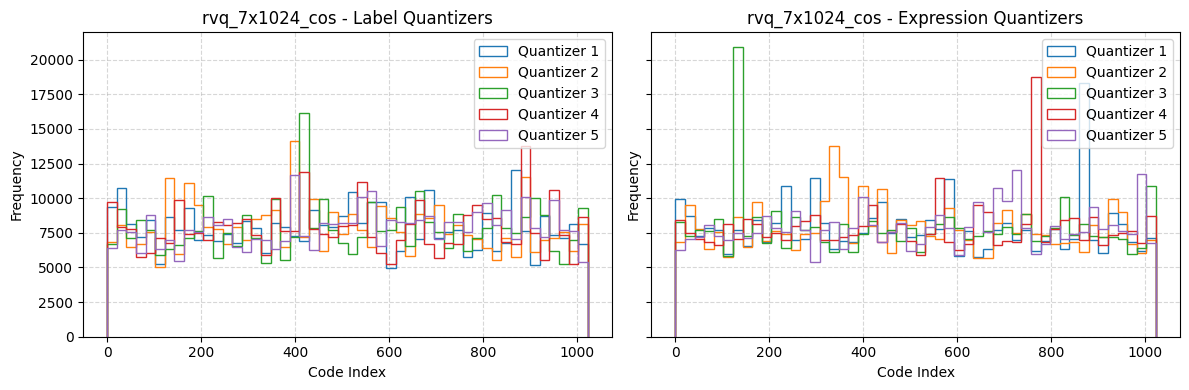

evaluating rvq_7x1024_l2

=== Model rvq_7x1024_l2 loaded ===


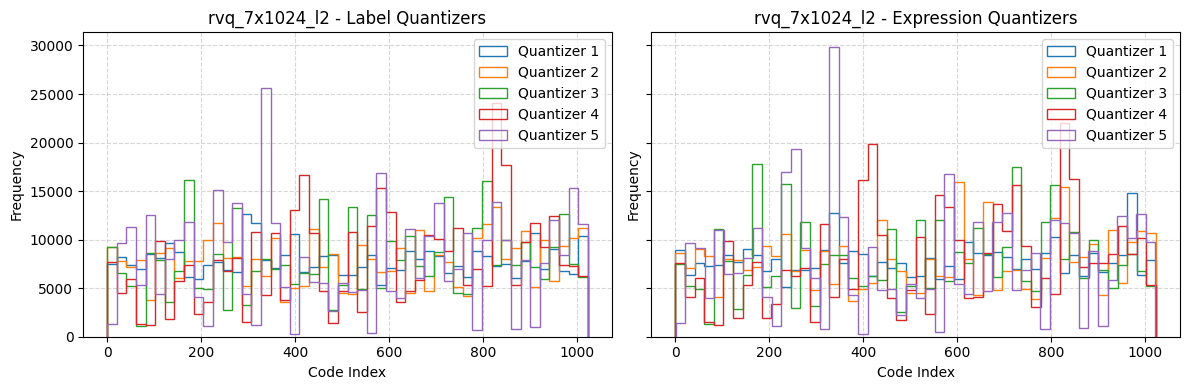

In [4]:
models = ['rvq_7x1024_cos', 'rvq_7x1024_l2']

embeddings = torch.load(fc["embedding_save_path"] + f"/sapbert_lora_triplet16.pt")
embedding_exp = embeddings["expressions_embeddings"]
embedding_label = embeddings["labels_embeddings"]

for config in cfg.codebook_config:
    if config['model_name'] in models:
        print(f"evaluating {config['model_name']}")
        model, config_id = load_model(cfg, config)

        _, indices_exp = evaluate(model, embedding_exp)  # shape: [1, N, 7]
        _, indices_label = evaluate(model, embedding_label)  # shape: [1, N, 7]

        indices_exp = indices_exp.cpu().squeeze(0)   # [N, 7]
        indices_label = indices_label.cpu().squeeze(0)  # [N, 7]

        # Plot as 1x2 subplots: (left = label, right = expression)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
        for i in range(5):
            axes[0].hist(indices_label[:, i], bins=50, histtype="step", label=f"Quantizer {i+1}")
            axes[1].hist(indices_exp[:, i], bins=50, histtype="step", label=f"Quantizer {i+1}")

        axes[0].set_title(f"{config_id} - Label Quantizers")
        axes[1].set_title(f"{config_id} - Expression Quantizers")

        for ax in axes:
            ax.set_xlabel("Code Index")
            ax.set_ylabel("Frequency")
            ax.legend(loc="upper right")
            ax.grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()




evaluating rvq_7x1024_cos

=== Model rvq_7x1024_cos loaded ===


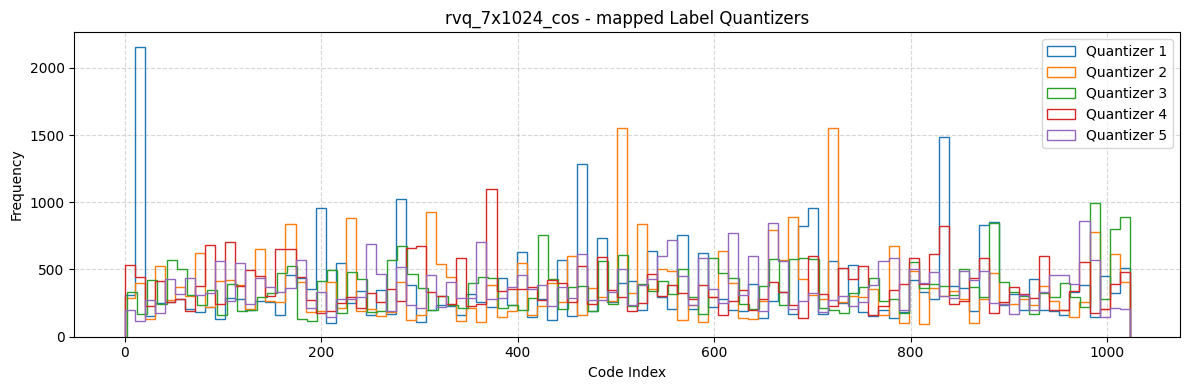

evaluating rvq_7x1024_l2

=== Model rvq_7x1024_l2 loaded ===


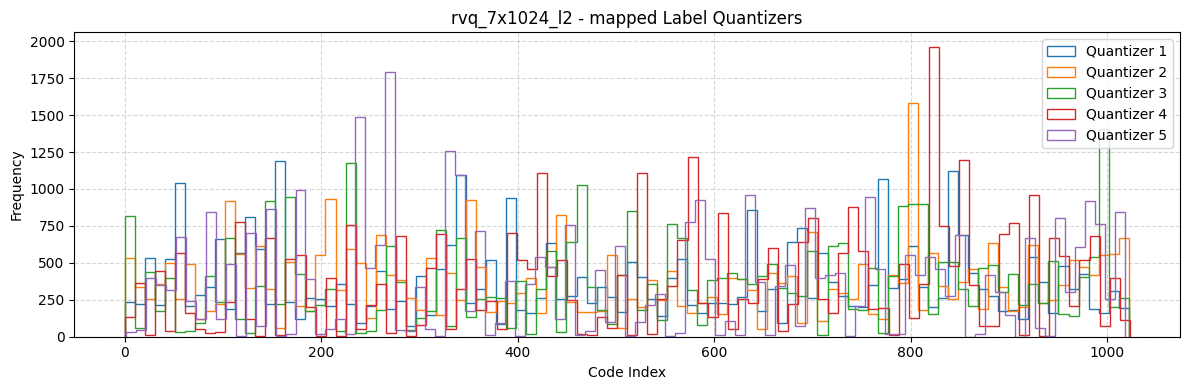

In [10]:

df_concept_all = pl.read_parquet(fc["path_all_concept"])
models = ['rvq_7x1024_cos', 'rvq_7x1024_l2']
df_mapped = pl.read_csv(fc["mapped_concept"])
idx_mapped = df_mapped.join(df_concept_all, left_on="n.id", right_on="id")['idx'].unique().to_list()

# === Load and filter embeddings ===
embedding_mapped = embedding_label[idx_mapped, :]  # [N', 768]


for config in cfg.codebook_config:
    if config['model_name'] in models:
        print(f"evaluating {config['model_name']}")
        model, config_id = load_model(cfg, config)

        _, indices_mapped = evaluate(model, embedding_mapped)  # shape: [1, N, 7]

        indices_mapped = indices_mapped.cpu().squeeze(0)   # [N, 7]

        # Plot as 1x2 subplots: (left = label, right = expression)
        fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharey=True)
        for i in range(5):
            ax.hist(indices_mapped[:, i], bins=100, histtype="step", label=f"Quantizer {i+1}")

        ax.set_title(f"{config_id} - mapped Label Quantizers")

        ax.set_xlabel("Code Index")
        ax.set_ylabel("Frequency")
        ax.legend(loc="upper right")
        ax.grid(True, linestyle="--", alpha=0.5)

        plt.tight_layout()
        plt.show()


